In [97]:
import pandas as pd
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from tqdm import tqdm

In [98]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [99]:
import json
import pandas as pd

# Load the JSON file
file_path = './downloaded_data.json'  # Replace with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert the "datetime" field to a DataFrame
df = pd.DataFrame({'datetime': data['datetime'], 'Hp60': data['Hp60']})

In [100]:
def change_time(df):
    # Remove the 'Z' and convert to Pandas datetime format
    df['datetime'] = pd.to_datetime(df['datetime'].str.replace('Z', ''))

    # Separate components
    df['date'] = df['datetime'].dt.date       # Extract date
    df['time'] = df['datetime'].dt.time       # Extract time
    df['year'] = df['datetime'].dt.year       # Extract year
    df['month'] = df['datetime'].dt.month     # Extract month
    df['day'] = df['datetime'].dt.day         # Extract day
    df['hour'] = df['datetime'].dt.hour       # Extract hour

    df = df.drop(columns=['datetime','date','time'])
    
    return df

df = change_time(df)

In [101]:
train_df = df[df['year']!=2024]
test_df = df[df['year']==2024]

# Dataloader

In [102]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [103]:
class Sliding_window(Dataset):
    def __init__(self, df, X_point, y_point):
        self.df = df
        self.X_point = X_point
        self.y_point = y_point
        self.sequence24 = []
        self.sequence6 = []
        
        counter = 1
        temp_x = []
        temp_y = []
        for idx,i in enumerate(self.df['Hp60']):
            if counter <= self.X_point:
                temp_x.append(i)
            else:
                temp_y.append(i)
            
            if (idx + 1) % (X_point + y_point) == 0:
                self.sequence24.append(temp_x)
                self.sequence6.append(temp_y)
                temp_x = []
                temp_y = []
                counter = 0
             
            counter += 1    
    
    def __len__(self):
        return len(self.sequence24)

    def __getitem__(self, idx):
        data = torch.Tensor(self.sequence24[idx])
        label = torch.Tensor(self.sequence6[idx])
        
        return data, label


In [104]:
train_dataset = Sliding_window(df=train_df,
                         X_point=24,
                         y_point=6)
test_dataset = Sliding_window(df=test_df,
                         X_point=24,
                         y_point=6)

In [105]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [106]:
x,y = train_dataset[2:5]

In [107]:
x

tensor([[0.3330, 0.0000, 0.0000, 0.3330, 0.6670, 0.0000, 0.0000, 0.0000, 0.3330,
         0.3330, 0.6670, 0.6670, 1.3330, 0.0000, 0.0000, 0.0000, 0.0000, 0.3330,
         0.6670, 0.3330, 1.3330, 1.0000, 1.0000, 0.3330],
        [0.0000, 0.3330, 0.3330, 0.3330, 0.6670, 0.6670, 2.6670, 1.6670, 2.0000,
         1.0000, 1.3330, 1.0000, 1.3330, 1.6670, 1.0000, 0.0000, 0.6670, 1.3330,
         3.0000, 4.6670, 4.0000, 3.3330, 2.6670, 1.3330],
        [3.0000, 3.6670, 3.3330, 3.3330, 3.0000, 2.3330, 4.0000, 3.3330, 3.3330,
         2.3330, 2.6670, 3.0000, 2.3330, 2.0000, 2.3330, 1.3330, 2.0000, 2.0000,
         1.6670, 1.3330, 1.3330, 1.6670, 1.6670, 1.3330]])

In [108]:
y

tensor([[0.3330, 0.0000, 0.0000, 0.3330, 0.6670, 0.0000],
        [2.0000, 1.0000, 1.3330, 2.3330, 2.6670, 4.0000],
        [1.0000, 2.0000, 1.3330, 1.6670, 2.0000, 2.0000]])

# Train

In [109]:
class signal_model(nn.Module):
    def __init__(self, X_point, y_point, hidden_dim):
        super(signal_model, self).__init__()
        self.lstm = nn.LSTM(X_point, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, y_point)
        self.activation = nn.Softplus()
    
    def forward(self, sentences):
        lstm_out, _ = self.lstm(sentences)
        #print(lstm_out.shape)
        #lstm_out_last = lstm_out[:, -1, :]
        #print(lstm_out_last.shape)
        x = self.fc(lstm_out)
        #print(x.shape)
        x = self.activation(x)
        return x
    

In [110]:
model = signal_model(X_point=24, y_point=6,hidden_dim=50)
model

signal_model(
  (lstm): LSTM(24, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=6, bias=True)
  (activation): Softplus(beta=1.0, threshold=20.0)
)

In [111]:
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 20

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.
    
    train_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
    for i, (inputs, futures) in enumerate(train_dataloader):
        inputs, futures = inputs, futures
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, futures)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.4f}")
    running_loss = 0.0

Epoch 1/20: 100%|██████████| 28/28 [00:00<00:00, 242.87it/s]


Epoch: 1, Batch: 28, Loss: 0.3485


Epoch 2/20: 100%|██████████| 28/28 [00:00<00:00, 377.26it/s]


Epoch: 2, Batch: 28, Loss: 0.2564


Epoch 3/20: 100%|██████████| 28/28 [00:00<00:00, 374.81it/s]


Epoch: 3, Batch: 28, Loss: 0.2409


Epoch 4/20: 100%|██████████| 28/28 [00:00<00:00, 365.57it/s]


Epoch: 4, Batch: 28, Loss: 0.2360


Epoch 5/20: 100%|██████████| 28/28 [00:00<00:00, 265.84it/s]


Epoch: 5, Batch: 28, Loss: 0.2311


Epoch 6/20: 100%|██████████| 28/28 [00:00<00:00, 378.91it/s]


Epoch: 6, Batch: 28, Loss: 0.2312


Epoch 7/20: 100%|██████████| 28/28 [00:00<00:00, 384.94it/s]


Epoch: 7, Batch: 28, Loss: 0.2294


Epoch 8/20: 100%|██████████| 28/28 [00:00<00:00, 262.02it/s]


Epoch: 8, Batch: 28, Loss: 0.2226


Epoch 9/20: 100%|██████████| 28/28 [00:00<00:00, 373.13it/s]


Epoch: 9, Batch: 28, Loss: 0.2191


Epoch 10/20: 100%|██████████| 28/28 [00:00<00:00, 317.83it/s]


Epoch: 10, Batch: 28, Loss: 0.2181


Epoch 11/20: 100%|██████████| 28/28 [00:00<00:00, 229.32it/s]


Epoch: 11, Batch: 28, Loss: 0.2152


Epoch 12/20: 100%|██████████| 28/28 [00:00<00:00, 344.86it/s]


Epoch: 12, Batch: 28, Loss: 0.2130


Epoch 13/20: 100%|██████████| 28/28 [00:00<00:00, 360.43it/s]


Epoch: 13, Batch: 28, Loss: 0.2098


Epoch 14/20: 100%|██████████| 28/28 [00:00<00:00, 252.60it/s]


Epoch: 14, Batch: 28, Loss: 0.2116


Epoch 15/20: 100%|██████████| 28/28 [00:00<00:00, 369.12it/s]


Epoch: 15, Batch: 28, Loss: 0.2002


Epoch 16/20: 100%|██████████| 28/28 [00:00<00:00, 373.13it/s]


Epoch: 16, Batch: 28, Loss: 0.1980


Epoch 17/20: 100%|██████████| 28/28 [00:00<00:00, 255.29it/s]


Epoch: 17, Batch: 28, Loss: 0.1974


Epoch 18/20: 100%|██████████| 28/28 [00:00<00:00, 349.19it/s]


Epoch: 18, Batch: 28, Loss: 0.1873


Epoch 19/20: 100%|██████████| 28/28 [00:00<00:00, 372.80it/s]


Epoch: 19, Batch: 28, Loss: 0.1861


Epoch 20/20: 100%|██████████| 28/28 [00:00<00:00, 386.31it/s]

Epoch: 20, Batch: 28, Loss: 0.1795


# Test

In [112]:
model.eval()

total_loss = 0
total_samples = 0

all_predictions = []
all_ground_truths = [] 
# Wrap the test dataloader with tqdm
test_dataloader = tqdm(test_dataloader, desc="Evaluation")

with torch.no_grad():
    for inputs, futures in test_dataloader:
        inputs, futures = inputs, futures
        
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, futures)
        total_loss += loss.item() * inputs.size(0)  # Accumulate loss
        total_samples += inputs.size(0)
        
        all_predictions.append(outputs)
        all_ground_truths.append(futures)
        
avg_loss = total_loss / total_samples
print("avg_loss",avg_loss)
print("total_loss",total_loss)
print("total_samples",total_samples)

Evaluation: 100%|██████████| 9/9 [00:00<00:00, 1096.90it/s]

avg_loss 1.2846417816061722
total_loss 366.1229077577591
total_samples 285


In [113]:
print("avg_loss",avg_loss)
print("total_loss",total_loss)
print("total_samples",total_samples)

avg_loss 1.2846417816061722
total_loss 366.1229077577591
total_samples 285


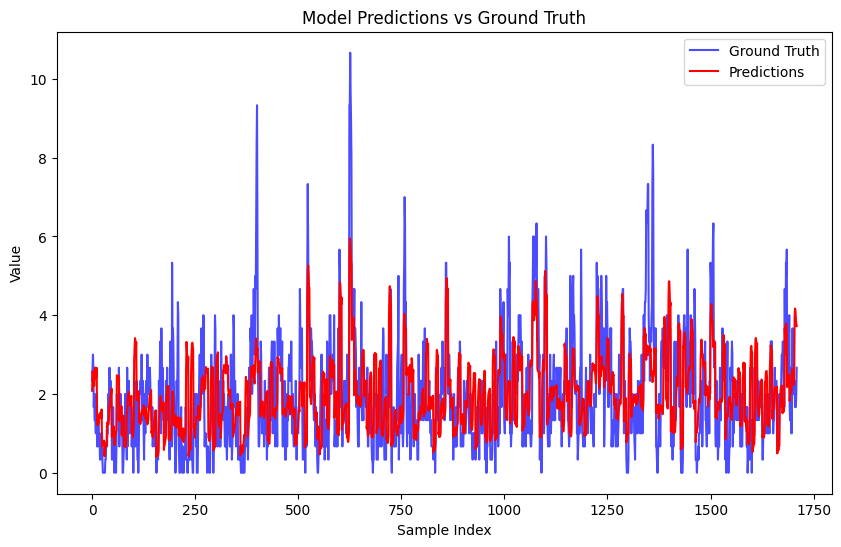

In [114]:
# Convert saved outputs and ground truths into tensors
all_predictions = torch.cat(all_predictions, dim=0)
all_ground_truths = torch.cat(all_ground_truths, dim=0)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(all_ground_truths.numpy().flatten(), label='Ground Truth', color='blue', alpha=0.7)
plt.plot(all_predictions.numpy().flatten(), label='Predictions', color='red', alpha=1)
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Model Predictions vs Ground Truth')
plt.show()

In [115]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(all_ground_truths, all_predictions)
mse = mean_squared_error(all_ground_truths, all_predictions) 

print('mae',mae)
print('mse',mse)

mae 0.852368077635765
mse 1.284641817029864
